In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os
import sys
sys.path.append("/Users/bovy/Repos/tgas-completeness/py/")
import tqdm
import numpy
import pickle
from scipy.stats import skew, skewtest
from extreme_deconvolution import extreme_deconvolution
import gaia_tools.load, gaia_tools.xmatch
from galpy.util import bovy_plot, bovy_coords, save_pickles
import effsel # from tgas-completeness
from effsel import main_sequence_cut_r
%pylab inline
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import NullFormatter, FuncFormatter, LogFormatter
from matplotlib import gridspec
import copy
save_figures= False
numpy.random.seed(3)

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# The kinematics of local F stars

Load the TGAS and 2MASS data that we use, among other things, select F-type stars:

In [3]:
# Load TGAS and 2MASS
tgas= gaia_tools.load.tgas()
twomass= gaia_tools.load.twomass()
jk= twomass['j_mag']-twomass['k_mag']
dm= -5.*numpy.log10(tgas['parallax'])+10.
mj= twomass['j_mag']-dm

Load the dwarf locus and select TGAS F-type stars with good parallaxes:

In [4]:
# Select F stars
sp= effsel.load_spectral_types()
sptype= 'F'
jkmin= (sp['JH']+sp['HK'])[sp['SpT']=='%s0V' % sptype]
if sptype == 'M':
    jkmax= (sp['JH']+sp['HK'])[sp['SpT']=='%s5V' % sptype]
else:
    jkmax= (sp['JH']+sp['HK'])[sp['SpT']=='%s9V' % sptype]
jmin= main_sequence_cut_r(jkmax)
jmax= main_sequence_cut_r(jkmin)
good_plx_indx= (tgas['parallax']/tgas['parallax_error'] > 10.)*(jk != 0.)
good_sampling= good_plx_indx*(jk > jkmin)*(jk < jkmax)\
                *(mj < main_sequence_cut_r(jk,tight=False,low=True))\
                *(mj > main_sequence_cut_r(jk,tight=False))
print("Found %i F stars in TGAS with good parallaxes" % (numpy.sum(good_sampling)))
tgas= tgas[good_sampling]
twomass= twomass[good_sampling]
jk= jk[good_sampling]
dm= dm[good_sampling]
mj=mj[good_sampling]

Found 103603 F stars in TGAS with good parallaxes


## Using XD to get $\sigma_{v_z}$ from the *TGAS* data alone

We will determine $\sigma_{v_z}^2$ from the *TGAS* data alone by, that is, just using the *TGAS* parallaxes and proper motions. This only works close to the plane, because further away the $v_z$ component of the velocity only weakly projects onto the proper motions. First we compute the linear velocity in RA and Dec and propagate the correlated parallax and proper-motion uncertainties to this vector. We then model this vector as being a 2D projection of the 3D velocity distribution in $(v_x,v_y,v_z)$, where we are mainly interested in the $v_z$ component and so we do not have to worry too much about the in-plane $(v_x,v_y)$ velocity distribution.

In [5]:
# Compute XYZ
lb= bovy_coords.radec_to_lb(tgas['ra'],tgas['dec'],degree=True,epoch=None)
XYZ= bovy_coords.lbd_to_XYZ(lb[:,0],lb[:,1],1./tgas['parallax'],degree=True)

In [6]:
# Generate vradec
vradec= numpy.array([bovy_coords._K/tgas['parallax']*tgas['pmra'],
                     bovy_coords._K/tgas['parallax']*tgas['pmdec']])
#First calculate the transformation matrix T
epoch= None
theta,dec_ngp,ra_ngp= bovy_coords.get_epoch_angles(epoch)
Tinv= numpy.dot(numpy.array([[numpy.cos(ra_ngp),-numpy.sin(ra_ngp),0.],
                             [numpy.sin(ra_ngp),numpy.cos(ra_ngp),0.],
                             [0.,0.,1.]]),
                numpy.dot(numpy.array([[-numpy.sin(dec_ngp),0.,numpy.cos(dec_ngp)],
                                       [0.,1.,0.],
                                       [numpy.cos(dec_ngp),0.,numpy.sin(dec_ngp)]]),
                          numpy.array([[numpy.cos(theta),numpy.sin(theta),0.],
                                       [numpy.sin(theta),-numpy.cos(theta),0.],
                                       [0.,0.,1.]])))# Calculate all projection matrices
ra= tgas['ra']/180.*numpy.pi
dec= tgas['dec']/180.*numpy.pi
A1= numpy.array([[numpy.cos(dec),numpy.zeros(len(tgas)),numpy.sin(dec)],
                 [numpy.zeros(len(tgas)),numpy.ones(len(tgas)),numpy.zeros(len(tgas))],
                 [-numpy.sin(dec),numpy.zeros(len(tgas)),numpy.cos(dec)]])
A2= numpy.array([[numpy.cos(ra),numpy.sin(ra),numpy.zeros(len(tgas))],
                 [-numpy.sin(ra),numpy.cos(ra),numpy.zeros(len(tgas))],
                 [numpy.zeros(len(tgas)),numpy.zeros(len(tgas)),numpy.ones(len(tgas))]])
TAinv= numpy.empty((len(tgas),3,3))
for jj in range(len(tgas)):
    TAinv[jj]= numpy.dot(numpy.dot(A1[:,:,jj],A2[:,:,jj]),Tinv)
proj= TAinv[:,1:]

In [7]:
# Sample from the joint (parallax,proper motion) uncertainty distribution to get the covariance matrix of the vradec
nmc= 10001
# Need to sample from the (parallax,proper-motion covariance matrix)
vradec_cov= numpy.empty((len(tgas),2,2))
for ii in tqdm.trange(len(tgas)):
    # Construct covariance matrixx
    tcov= numpy.zeros((3,3))
    tcov[0,0]= tgas['parallax_error'][ii]**2./2. # /2 because of symmetrization below
    tcov[1,1]= tgas['pmra_error'][ii]**2./2.
    tcov[2,2]= tgas['pmdec_error'][ii]**2./2.
    tcov[0,1]= tgas['parallax_pmra_corr'][ii]*tgas['parallax_error'][ii]*tgas['pmra_error'][ii]
    tcov[0,2]= tgas['parallax_pmdec_corr'][ii]*tgas['parallax_error'][ii]*tgas['pmdec_error'][ii]
    tcov[1,2]= tgas['pmra_pmdec_corr'][ii]*tgas['pmra_error'][ii]*tgas['pmdec_error'][ii]
    # symmetrize
    tcov= (tcov+tcov.T)
    # Cholesky decomp.
    L= numpy.linalg.cholesky(tcov)
    tsam= numpy.tile((numpy.array([tgas['parallax'][ii],tgas['pmra'][ii],tgas['pmdec'][ii]])),(nmc,1)).T
    tsam+= numpy.dot(L,numpy.random.normal(size=(3,nmc)))
    tvradec= numpy.array([bovy_coords._K/tsam[0]*tsam[1],
                          bovy_coords._K/tsam[0]*tsam[2]])
    vradec_cov[ii]= numpy.cov(tvradec)

If we use the same bins as those in which we computed the density, we have the following number of stars in each bin:

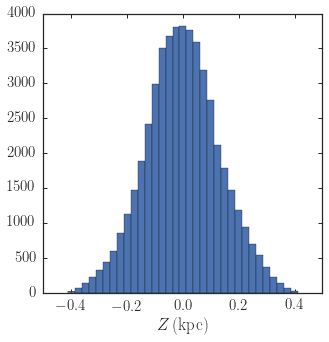

In [8]:
zbins= numpy.arange(-0.4125,0.425,0.025)
indx= (numpy.fabs(XYZ[:,2]) > -0.4125)\
      *(numpy.fabs(XYZ[:,2]) <= 0.4125)\
      *(numpy.sqrt(XYZ[:,0]**2.+XYZ[:,1]**2.) < 0.2)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
_= hist(XYZ[indx,2],bins=zbins)
xlabel(r'$Z\,(\mathrm{kpc})$')

Now we perform an example fit:

In [9]:
def combined_sig2(amp,mean,covar):
    indx= numpy.sqrt(covar) < 30.
    tamp= amp[indx]/numpy.sum(amp[indx])
    return (numpy.sum(tamp*(covar+mean**2.)[indx])-numpy.sum(tamp*mean[indx])**2.)

In [10]:
# Fit with mix of Gaussians
ii= 14
print("Z/pc:",500.*(numpy.roll(zbins,-1)+zbins)[:-1][ii])
indx= (XYZ[:,2] > zbins[ii])\
      *(XYZ[:,2] <= zbins[ii+1])\
      *(numpy.sqrt(XYZ[:,0]**2.+XYZ[:,1]**2.) < 0.2)
ydata= vradec.T[indx]
ycovar= vradec_cov[indx]
ngauss= 2
initamp= numpy.random.uniform(size=ngauss)
initamp/= numpy.sum(initamp)
m= numpy.zeros(3)
s= numpy.array([40.,40.,20.])
initmean= []
initcovar= []
for ii in range(ngauss):
    initmean.append(m+numpy.random.normal(size=3)*s)
    initcovar.append(4.*s**2.*numpy.diag(numpy.ones(3)))
initcovar= numpy.array(initcovar)
initmean= numpy.array(initmean)
print("lnL",extreme_deconvolution(ydata,ycovar,initamp,initmean,initcovar,projection=proj[indx]))
print("amp, mean, std. dev.",initamp,initmean[:,2],numpy.sqrt(initcovar[:,2,2]))
print("Combined <v^2>, sqrt(<v^2>):",combined_sig2(initamp,initmean[:,2],initcovar[:,2,2]),
      numpy.sqrt(combined_sig2(initamp,initmean[:,2],initcovar[:,2,2])))

('Z/pc:', -49.999999999999659)
/Users/bovy/Repos/extreme-deconvolution/py/extreme_deconvolution.py:374: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if projection == None:

('lnL', -8.424159243180295)
('amp, mean, std. dev.', array([ 0.3276312,  0.6723688]), array([-7.03817248, -7.72725707]), array([ 16.44557343,   7.52963938]))
('Combined <v^2>, sqrt(<v^2>):', 126.83497901809923, 11.262103667525851)


The following function computes a bootstrap estimate of the uncertainty in $\sigma_{v_z}$:

In [11]:
def bootstrap(nboot,vrd,vrd_cov,proj,ngauss=2):
    out= numpy.empty(nboot)
    for ii in range(nboot):
        # Draw w/ replacement
        indx= numpy.floor(numpy.random.uniform(size=len(vrd))*len(vrd)).astype('int')
        ydata= vrd[indx]
        ycovar= vrd_cov[indx]
        initamp= numpy.random.uniform(size=ngauss)
        initamp/= numpy.sum(initamp)
        m= numpy.zeros(3)
        s= numpy.array([40.,40.,20.])
        initmean= []
        initcovar= []
        for jj in range(ngauss):
            initmean.append(m+numpy.random.normal(size=3)*s)
            initcovar.append(4.*s**2.*numpy.diag(numpy.ones(3)))
        initcovar= numpy.array(initcovar)
        initmean= numpy.array(initmean)
        lnL= extreme_deconvolution(ydata,ycovar,initamp,initmean,initcovar,projection=proj[indx])
        out[ii]= combined_sig2(initamp,initmean[:,2],initcovar[:,2,2])
    return out

A test case:

In [12]:
ii= 7
indx= (XYZ[:,2] > zbins[ii])\
      *(XYZ[:,2] <= zbins[ii+1])\
      *(numpy.sqrt(XYZ[:,0]**2.+XYZ[:,1]**2.) < 0.2)
b= bootstrap(20,vradec.T[indx],vradec_cov[indx],proj[indx],ngauss=2)

In [13]:
zbins[ii], numpy.mean(numpy.sqrt(b)), numpy.std(numpy.sqrt(b))

(-0.23749999999999982, 14.108752009032163, 2.6294685400345887)

Now we do the XD fit to each $Z$ bin and compute the uncertainty using bootstrap:

In [14]:
savefilename= 'Fstar-sigz.sav'
if not os.path.exists(savefilename):
    zbins= numpy.arange(-0.4125,0.425,0.025)
    nboot= 200
    nstar= numpy.zeros(len(zbins)-1)-1
    sig2z= numpy.zeros(len(zbins)-1)-1
    sig2z_err= numpy.zeros(len(zbins)-1)-1
    all_sam= numpy.zeros((len(zbins)-1,nboot))-1
    ngauss= 2
    start= 0
else:
    with open(savefilename,'rb') as savefile:
        out= (pickle.load(savefile),)
        while True:
            try:
                out= out+(pickle.load(savefile),)
            except EOFError:
                break
    zbins,sig2z,sig2z_err,nstar,all_sam,ngauss,nboot,start= out
for ii in tqdm.trange(start,len(zbins)-1):
    indx= (XYZ[:,2] > zbins[ii])\
           *(XYZ[:,2] <= zbins[ii+1])\
           *(numpy.sqrt(XYZ[:,0]**2.+XYZ[:,1]**2.) < 0.2)
    nstar[ii]= numpy.sum(indx)
    if numpy.sum(indx) < 30: continue
    # Basic XD fit
    ydata= vradec.T[indx]
    ycovar= numpy.zeros_like(vradec.T)[indx]
    initamp= numpy.random.uniform(size=ngauss)
    initamp/= numpy.sum(initamp)
    m= numpy.zeros(3)
    s= numpy.array([40.,40.,20.])
    initmean= []
    initcovar= []
    for jj in range(ngauss):
        initmean.append(m+numpy.random.normal(size=3)*s)
        initcovar.append(4.*s**2.*numpy.diag(numpy.ones(3)))
    initcovar= numpy.array(initcovar)
    initmean= numpy.array(initmean)
    lnL= extreme_deconvolution(ydata,ycovar,initamp,initmean,initcovar,projection=proj[indx])
    sig2z[ii]= combined_sig2(initamp,initmean[:,2],initcovar[:,2,2])
    sam= bootstrap(nboot,vradec.T[indx],vradec_cov[indx],proj[indx],ngauss=ngauss)
    all_sam[ii]= sam
    sig2z_err[ii]= 1.4826*numpy.median(numpy.fabs(sam-numpy.median(sam)))
    save_pickles(savefilename,zbins,sig2z,sig2z_err,nstar,all_sam,ngauss,nboot,ii+1)

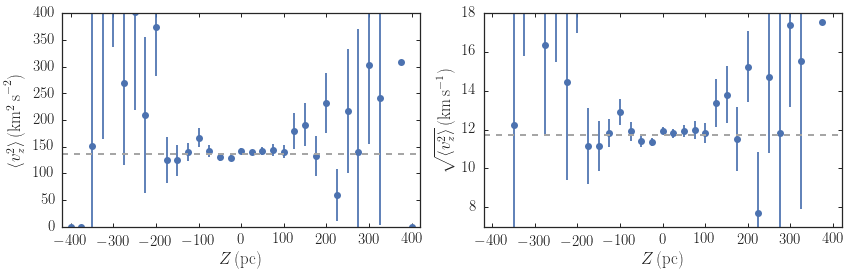

In [15]:
figsize(12,4)
subplot(1,2,1)
errorbar(500.*(numpy.roll(zbins,-1)+zbins)[:-1],
        sig2z,yerr=sig2z_err,ls='None',marker='o')
axhline(11.7**2.,ls='--',color='0.65',lw=2.)
xlabel(r'$Z\,(\mathrm{pc})$')
ylabel(r'$\langle v_z^2 \rangle\,(\mathrm{km^2\,s}^{-2})$')
ylim(0.,400.)
xlim(-420,420)
subplot(1,2,2)
errorbar(500.*(numpy.roll(zbins,-1)+zbins)[:-1],
        numpy.sqrt(sig2z),yerr=0.5*sig2z_err/numpy.sqrt(sig2z),ls='None',marker='o')
ylim(7.,18.)
xlim(-420,420)
xlabel(r'$Z\,(\mathrm{pc})$')
ylabel(r'$\sqrt{\langle v_z^2 \rangle}\,(\mathrm{km\,s}^{-1})$')
axhline(11.7,ls='--',color='0.65',lw=2.)
tight_layout()